In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
import numpy as np
import importlib
import math

In [2]:
sys.path.append("/u/davidm/Documents/Master-thesis/Scripts/RNA-seq/python/")

In [3]:
import rnaseq
importlib.reload(rnaseq)

<module 'rnaseq' from '/u/davidm/Documents/Master-thesis/Scripts/RNA-seq/python/rnaseq/__init__.py'>

## Knee visualizations (example with BT20) 

In [4]:
sample = "Sample_BT20_N701"
quant_params = "trimmed-reads-cutadapt-all/decoys-k19-1.4.0/customWh-top-3000"
genref = "human/assembly__GRCh38-hg38/annotation__gencode/gencode_34"
project = "dsp992"
prefix = f"pyplot_{sample}"

In [5]:
f = pd.read_csv(f"/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/dsp992/quant/alevin/{genref}/{quant_params}/{sample}/alevin/raw_cb_frequency.txt", delimiter='\t', header = None)

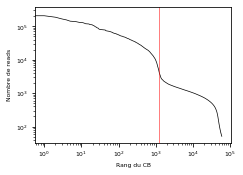

In [6]:
plt.subplots(figsize=(3.5,2.5))
plt.plot(f[1].values[f[1].values>50], c = 'black', linewidth = 0.7)
plt.yscale("log");
plt.xscale("log");
plt.axvline(1200, color='red',linewidth=0.5)
plt.xlabel("Rang du CB")
plt.ylabel("Nombre de reads")
plt.savefig(f"./figs/{prefix}_knee_rank.pdf")

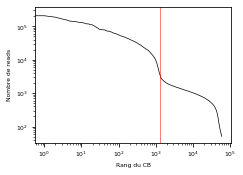

In [7]:
plt.subplots(figsize=(3.5,2.5))
plt.plot(f[1].values[f[1].values>50], c = 'black', linewidth = 0.7)
plt.yscale("log");
plt.xscale("log");
plt.axvline(1300, color='red',linewidth=0.5)
plt.xlabel("Rang du CB")
plt.ylabel("Nombre de reads")
plt.savefig(f"./figs/{prefix}_knee_rank.pdf")

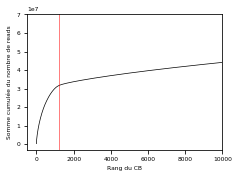

In [8]:
plt.subplots(figsize=(3.5,2.5))
plt.xlim(-500,10000)
plt.plot(np.cumsum(f[1].values[f[1].values>50]), c = 'black', linewidth = 0.7)
plt.axvline(1200, color='red', linewidth=0.5)
plt.xlabel("Rang du CB")
plt.ylabel("Somme cumulée du nombre de reads")
plt.savefig(f"./figs/{prefix}_knee_cumsum.pdf")

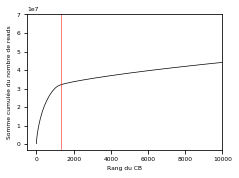

In [9]:
plt.subplots(figsize=(3.5,2.5))
plt.xlim(-500,10000)
plt.plot(np.cumsum(f[1].values[f[1].values>50]), c = 'black', linewidth = 0.7)
plt.axvline(1300, color='red', linewidth=0.5)
plt.xlabel("Rang du CB")
plt.ylabel("Somme cumulée du nombre de reads")
plt.savefig(f"./figs/{prefix}_knee_cumsum.pdf")

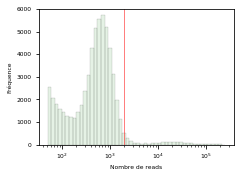

In [10]:
_,ax = plt.subplots(figsize=(3.5,2.5))
plt.axvline(f[1][2000], color='red',linewidth=0.5)
rnaseq.plotting.loghist(f[1].values[f[1].values>50], bins=50, ax=ax, fc=(0,0.5,0,0.1), edgecolor="black", linewidth=0.1)
plt.xlabel("Nombre de reads")
plt.ylabel("Fréquence")
plt.savefig(f"./figs/{prefix}_knee_dist.pdf");

## Double Poisson calculus to estimate the number of cells

In [11]:
def poisson(c,b, nc,nb,nd):
    pc = 1 if c=="any" else ((nc/nd)**c)*np.exp(-nc/nd)/math.factorial(c)
    pb = 1 if b=="any" else ((nb/nd)**b)*np.exp(-nb/nd)/math.factorial(b)
    return pc * pb

In [12]:
# Concentrations Drop-Seq paper

nd = 4 * 2 * 1e6 # number of droplets
nc = 4 * 100000 # number of cells
nb = 4 * 120000 # number of beads

In [13]:
# Concentrations lab experiments

nd = 1.2 * 2 * 1e6 # number of droplets
nc = 1.2 * 120000 # number of cells
nb = 1.2 * 120000 # number of beads

In [14]:
len(f) # Number of unique cell barcodes in read 1 file

2120841

### Some statistics

#### Empty droplets (no cell but at least one bead)

In [164]:
(poisson(c=0, b="any", nc=nc, nb = nb, nd = nd) - poisson(c=0, b=0, nc=nc, nb = nb, nd = nd))*nd

131625.8324810187

In [193]:
(poisson(c=0, b="any", nc=nc, nb = nb, nd = nd) - poisson(c=0, b=0, nc=nc, nb = nb, nd = nd))*nd * 0.4 # after washing the beads only get 20-40% 

52650.332992407486

##### Most of empty droplets contain 1 or 2 beads

In [203]:
(poisson(c=0, b=1, nc=nc, nb = nb, nd = nd) + 
poisson(c=0, b=2, nc=nc, nb = nb, nd = nd)) * nd * 0.4

52619.215669555524

##### Empty barcodes

In [226]:
# empty droplets contain 1 or 2 beads most of the time ; after washing only get 20-40% 

e = (poisson(c=0, b=1, nc=nc, nb = nb, nd = nd) + 
poisson(c=0, b=2, nc=nc, nb = nb, nd = nd) * 2) * nd * 0.4

print(e)

54151.81418420277


In [227]:
130000*0.4

52000.0

#### Number of droplets containing a least one bead and one cell

In [179]:
(1 - (poisson(c=0, b="any", nc=nc, nb = nb, nd = nd) +\
     poisson(c='any', b=0, nc=nc, nb = nb, nd = nd) -\
     poisson(c=0, b=0, nc=nc, nb = nb, nd = nd))) * nd

8139.286916784361

In [214]:
# after washing the beads only get 20-40% 

bc = (1 - (poisson(c=0, b="any", nc=nc, nb = nb, nd = nd) +\
     poisson(c='any', b=0, nc=nc, nb = nb, nd = nd) -\
     poisson(c=0, b=0, nc=nc, nb = nb, nd = nd))) * nd * 0.4 

print(bc)

3255.7147667137447


#### More than one bead and one cell

In [168]:
(1 - (poisson(c=1, b=1, nc=nc, nb = nb, nd = nd) +\
     poisson(c="any", b=0, nc=nc, nb = nb, nd = nd)+\
     poisson(c=0, b="any", nc=nc, nb = nb, nd = nd) -\
     poisson(c=0, b=0, nc=nc, nb = nb, nd = nd))) * nd

476.2943435481226

In [235]:
(poisson(c=1, b=2, nc=nc, nb = nb, nd = nd) +\
     poisson(c=2, b=1, nc=nc, nb = nb, nd = nd)) * nd 

459.77955439417445

### Good barcodes vs doublet expectations

#### Exactly one bead and one cell

In [15]:
poisson(c=1, b=1, nc=nc, nb = nb, nd = nd) * nd

7662.99257323624

In [16]:
good_bc = poisson(c=1, b=1, nc=nc, nb = nb, nd = nd) * nd * 0.2
print(good_bc)

1532.598514647248


In [17]:
good_bc = poisson(c=1, b=1, nc=nc, nb = nb, nd = nd) * nd * 0.4
print(good_bc)

3065.197029294496


In [18]:
nc=80000
good_bc = poisson(c=1, b=1, nc=nc, nb = nb, nd = nd) * nd * 0.2
print(good_bc)

874.4542269557877


In [19]:
nc=80000
good_bc = poisson(c=1, b=1, nc=nc, nb = nb, nd = nd) * nd * 0.4
print(good_bc)

1748.9084539115754


#### Bead doublets

In [20]:
(1 - (poisson(c="any", b=1, nc=nc, nb = nb, nd = nd) -
        poisson(c=0, b=1, nc=nc, nb = nb, nd = nd) +
        poisson(c="any", b=0, nc=nc, nb = nb, nd = nd) +
        poisson(c=0, b="any", nc=nc, nb = nb, nd = nd) -
        poisson(c=0, b=0, nc=nc, nb = nb, nd = nd))) * nd

136.08683769419372

##### Most of bead doublets are 2 beads and one cell

In [21]:
poisson(c=1, b=2, nc=nc, nb = nb, nd = nd) * nd # 2 beads and 1 cell

131.16813404336813

In [22]:
poisson(c=2, b=2, nc=nc, nb = nb, nd = nd) * nd # 2 beads and 2 cells

2.186135567389469

##### Bead doublet barcodes

In [25]:
# droplets with bead doublets contain 2 beads most of the time ; after washing only get 20-40% 

db = poisson(c=2, b=1, nc=nc, nb = nb, nd = nd) * nd * 2 *  0.4  
print(db)

58.296948463719175


#### Cell doublets

In [26]:
(1 - (poisson(c=1, b="any", nc=nc, nb = nb, nd = nd) -
        poisson(c=1, b=0, nc=nc, nb = nb, nd = nd) +
        poisson(c="any", b=0, nc=nc, nb = nb, nd = nd) +
        poisson(c=0, b="any", nc=nc, nb = nb, nd = nd) -
        poisson(c=0, b=0, nc=nc, nb = nb, nd = nd))) * nd

75.94317154655528

##### Most of cell doublets are 2 cells and one bead

In [27]:
poisson(c=2, b=1, nc=nc, nb = nb, nd = nd) * nd # 2 cells and 1 bead 

72.87118557964897

##### Cell doublet barcodes

In [28]:
# after washing only get 20-40% 

dc = poisson(c=2, b=1, nc=nc, nb = nb, nd = nd) * nd * 0.4  
print(dc)

29.148474231859588


#### Cell doublet rate

In [29]:
dc

29.148474231859588

In [30]:
dc/(good_bc+dc+db)

0.015873015873015872

In [31]:
100/3300

0.030303030303030304

#### Bead doublet rate

In [32]:
db

58.296948463719175

In [33]:
db/(good_bc+dc+db)

0.031746031746031744

In [34]:
200/3300

0.06060606060606061